# Autoencoders 

Autoencoders are neural networks that learn low-dimensional latent representations from which the original data can be reconstructed as well as possible.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

data_with_labels = pd.read_csv("../data/tomato_with_targets.txt", index_col=0)
labels = ['species','position','tissue','root']
data_original = data_with_labels.drop(columns = labels, axis = 1).to_numpy()
scaler = StandardScaler().set_output(transform="default")
data = scaler.fit_transform(data_original)

In [ ]:
# For Colab
#import os
#os.environ["KERAS_BACKEND"] = "torch"

In [3]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
#from keras import backend as K
#from keras import utils as Ku
import keras

In [4]:
# for debugging
# import keras
keras.config.disable_traceback_filtering()

In [20]:
tissue_dict = {'floral': 'gold', 'leaf': 'chartreuse', 'root': 'gray', 'sdling': 'mediumseagreen', 'stem': 'darkgreen', 'veg': 'purple'}
species_condition_dict = {'penn.Sun': 's', 'penn.Sh': 'd', 'M82.Sun': '^', 'M82.Sh': 'v'}
def plot_components(data_transformed, j=0, k=1, tissuelegend=True, legendloc="upper right"):
    for i in range(0,data_transformed.shape[0]):
        plt.scatter(data_transformed[i,j], data_transformed[i,k], marker=species_condition_dict['.'.join([data_with_labels.iloc[i]['species'], data_with_labels.iloc[i]['position']])], c=tissue_dict[data_with_labels.iloc[i]['tissue']])
    plt.xlabel("Component {}".format(j)) 
    plt.ylabel("Component {}".format(k))
    if tissuelegend:
        plt.legend(tissue_dict, loc=legendloc)
    else:
        def make_markers(ind):
            return(plt.Line2D([], [], color='black', marker=list(species_condition_dict.values())[ind], linestyle='None'))
        plt.legend([make_markers(l) for l in range(0,len(species_condition_dict.values()))], species_condition_dict.keys(), loc=legendloc)
    plt.show()

def autoencoder(X, n_components=2):  
    keras.utils.set_random_seed(42) 
    #seed_generator = keras.random.SeedGenerator(42)
        
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = keras.random.normal(shape=(n_components,), seed=42) # seed=seed_generator
        return z_mean + keras.ops.exp(z_log_var) * epsilon

    layer_sizes = [64,32,16,8]
    #encoder
    inputs = Input(shape=(X.shape[1],), name='encoder_input')
    x = inputs
    for size in layer_sizes:
        x = Dense(size, activation='relu', kernel_initializer='glorot_normal')(x)

    z_mean = Dense(n_components, kernel_initializer='glorot_normal', name='latent_mean')(x)
    z_log_var = Dense(n_components, kernel_initializer='glorot_normal', name='latent_sigma')(x)

    z = Lambda(sampling, output_shape=(n_components,))([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    #decoder
    latent_inputs = Input(shape=(n_components,), name='decoder_input_sampling')
    x = latent_inputs
    for size in layer_sizes[::-1]:
        x = Dense(size, activation='relu', kernel_initializer='glorot_normal')(x)
    outputs = Dense(X.shape[1], activation=None, kernel_initializer='glorot_normal', name='decoder_output')(x)
    #outputs = Dense(X.shape[1], activation='sigmoid', kernel_initializer='he_uniform', name='decoder_output')(x)
    decoder = Model(latent_inputs, outputs, name='decoder')
        
    #autoencoder
    vae = Model(inputs, decoder(encoder(inputs)[2]), name='vae')

    def vae_loss(x, x_decoded_mean):
        reconstruction_loss = keras.ops.mean(keras.ops.square((x-x_decoded_mean)))
        kl_loss = - 0.5 * keras.ops.mean(1 + z_log_var - keras.ops.square(z_mean) - keras.ops.exp(z_log_var), axis=-1)
        return reconstruction_loss + kl_loss
    
    #vae.compile(optimizer=keras.optimizers.Adam(), loss=vae_loss, run_eagerly=False)
    vae.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError(), run_eagerly=False)
    vae.fit(x=X,y=X, epochs=30, verbose=1, batch_size=24)
    
    Y_VAE = encoder.predict(X)[0]
    
    plot_components(Y_VAE)


In [8]:
print(data.shape)

(24, 28298)


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8359
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.8333
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8316
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8301
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8291
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8280
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8271
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8262
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8254
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8247
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8238
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8228
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8216
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8202
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8187
Epoch 16/30
1/1 ━━━━━━━━━━━━━━━━━━━

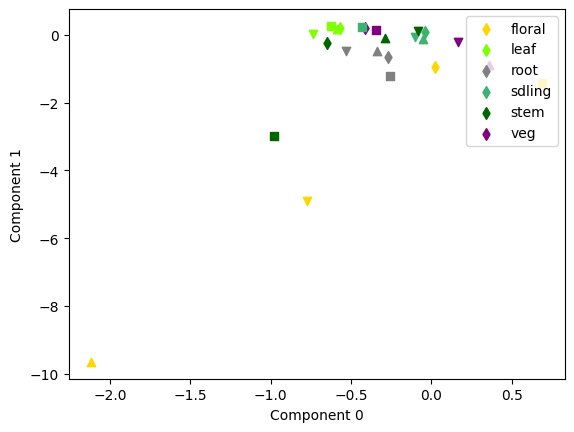

In [23]:
autoencoder(data[:,range(100)]) # just to try with smaller set

(70000, 28, 28, 1)


scArches, plain VAE or rna-seq-vae
Can we use any pretrained model for plants on our small dataset?
Points to mention: Avoid that samples are learned by heart – use regularization; latent space should have meaningful structure (e.g. show clustering of instances)